In [38]:
import os, random

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [77]:
TRAIN_END   = 202212
VAL_START   = 202301
VAL_END     = 202312
TEST_START  = 202401

In [40]:
import os
from pathlib import Path
import pandas as pd

BASE_DIR = Path(os.getcwd())
DATA_FILE = "/content/drive/MyDrive/지하철 4주 프로젝트/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv"
DATA_PATH = BASE_DIR / DATA_FILE

if not DATA_PATH.exists():
    raise FileNotFoundError(f"File not found at: {DATA_PATH}")
else:
    df_raw = pd.read_csv(DATA_PATH, encoding="cp949")
    print(f"Data loaded from: {DATA_PATH}")
    print(f"   → Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")

Data loaded from: /content/drive/MyDrive/지하철 4주 프로젝트/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv
   → Shape: 76,144 rows × 52 columns


In [41]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os
subway = pd.read_csv("/content/drive/MyDrive/지하철 4주 프로젝트/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv", encoding="cp949")

In [42]:
display(subway.shape)
display(subway.columns[:20])
display(subway.head(5))

(76144, 52)

Index(['사용월', '호선명', '지하철역', '04시-05시 승차인원', '04시-05시 하차인원', '05시-06시 승차인원',
       '05시-06시 하차인원', '06시-07시 승차인원', '06시-07시 하차인원', '07시-08시 승차인원',
       '07시-08시 하차인원', '08시-09시 승차인원', '08시-09시 하차인원', '09시-10시 승차인원',
       '09시-10시 하차인원', '10시-11시 승차인원', '10시-11시 하차인원', '11시-12시 승차인원',
       '11시-12시 하차인원', '12시-13시 승차인원'],
      dtype='object')

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,202508,1호선,동대문,396,24,10054,1708,8359,6219,13936,...,9674,760,2917,0,239,0,0,0,0,20250903
1,202508,1호선,동묘앞,166,5,2672,878,3728,5321,8349,...,4911,125,2020,1,215,0,0,0,0,20250903
2,202508,1호선,서울역,672,45,10600,9895,28477,56355,88208,...,29545,4209,7383,15,181,0,0,0,0,20250903
3,202508,1호선,시청,48,1,1902,5404,3872,28087,7288,...,3816,547,930,0,6,0,0,0,0,20250903
4,202508,1호선,신설동,389,19,8836,2142,9989,8530,21201,...,9451,373,2733,0,0,0,0,0,0,20250903


In [43]:
time_cols=[c for c in subway.columns if ('시-' in str(c)) and ('인원' in str(c))]

long_data=subway.melt(id_vars=['사용월','호선명','지하철역'],value_vars=time_cols,var_name='time_type',value_name='count')
long_data['inout']=long_data['time_type'].apply(lambda s:'승차' if '승차' in str(s) else '하차')
long_data['hour']=pd.to_numeric(long_data['time_type'].str.extract(r'(\d{1,2})시')[0],errors='coerce')
long_data=long_data.dropna(subset=['hour']).copy()
long_data['hour']=long_data['hour'].astype(int)
long_data['count']=pd.to_numeric(long_data['count'],errors='coerce')
long_data=long_data[['사용월','호선명','지하철역','hour','inout','count']]

In [44]:
print('size:',long_data.shape)
print(long_data.dtypes)
print('missing:\n',long_data.isna().sum())

size: (3654912, 6)
사용월       int64
호선명      object
지하철역     object
hour      int64
inout    object
count     int64
dtype: object
missing:
 사용월      0
호선명      0
지하철역     0
hour     0
inout    0
count    0
dtype: int64


In [45]:
num_cols=long_data.select_dtypes(include='number').columns.tolist()
cat_cols=[c for c in long_data.columns if c not in num_cols]
print('numeric:',num_cols)
print('categorical:',cat_cols)

numeric: ['사용월', 'hour', 'count']
categorical: ['호선명', '지하철역', 'inout']


In [46]:
agg=long_data.pivot_table(index=['사용월','호선명','지하철역','hour'],columns='inout',values='count',aggfunc='sum').reset_index()
if '승차' not in agg: agg['승차']=0
if '하차' not in agg: agg['하차']=0
agg['congestion']=agg['승차']+agg['하차']
display('agg size:',agg.shape);print(agg.head())

'agg size:'

(1825440, 7)

inout     사용월  호선명 지하철역  hour   승차    하차  congestion
0      201501  1호선  동대문     0  915  5095        6010
1      201501  1호선  동대문     1    3    41          44
2      201501  1호선  동대문     2    0     0           0
3      201501  1호선  동대문     3    0     0           0
4      201501  1호선  동대문     4  413     7         420


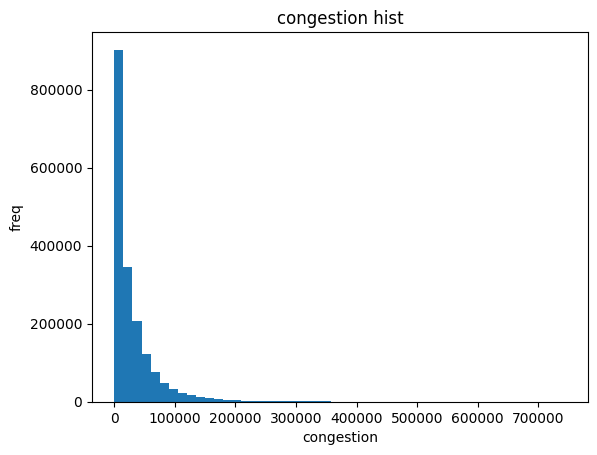

In [47]:
plt.figure()
plt.hist(agg['congestion'],bins=50)
plt.title('congestion hist')
plt.xlabel('congestion')
plt.ylabel('freq')
plt.show()

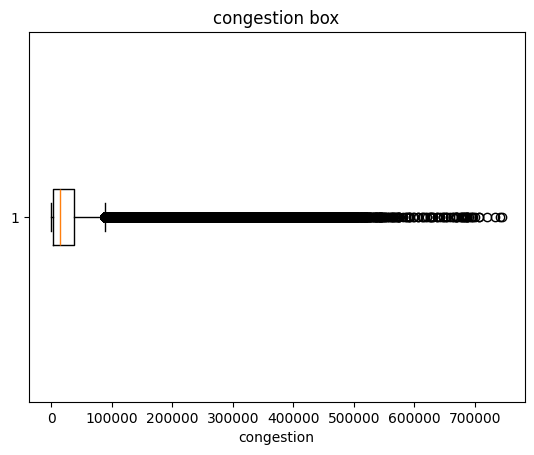

In [48]:
plt.figure()
plt.boxplot(agg['congestion'],vert=False,showfliers=True)
plt.title('congestion box')
plt.xlabel('congestion')
plt.show()

In [49]:
print(agg[['hour','승차','하차','congestion']].corr())

inout           hour        승차        하차  congestion
inout                                               
hour        1.000000  0.217233  0.243211    0.256299
승차          0.217233  1.000000  0.615513    0.896603
하차          0.243211  0.615513  1.000000    0.900881
congestion  0.256299  0.896603  0.900881    1.000000


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


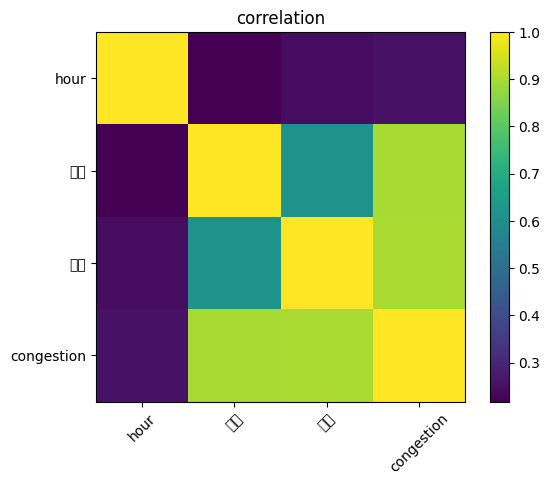

In [50]:
c=agg[['hour','승차','하차','congestion']].corr().values
plt.figure()
plt.imshow(c,interpolation='nearest')
plt.colorbar()
plt.xticks(range(4),['hour','승차','하차','congestion'],rotation=45)
plt.yticks(range(4),['hour','승차','하차','congestion'])
plt.title('correlation')
plt.show()

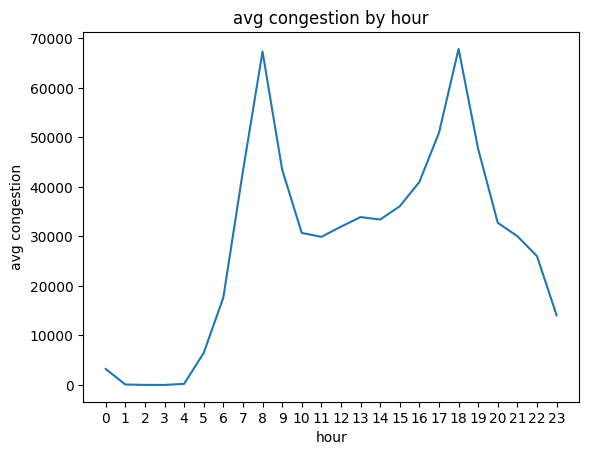

In [51]:
h=agg.groupby('hour')['congestion'].mean().reset_index()
plt.figure()
plt.plot(h['hour'],h['congestion'])
plt.title('avg congestion by hour')
plt.xlabel('hour')
plt.ylabel('avg congestion')
plt.xticks(range(h['hour'].min(),h['hour'].max()+1))
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


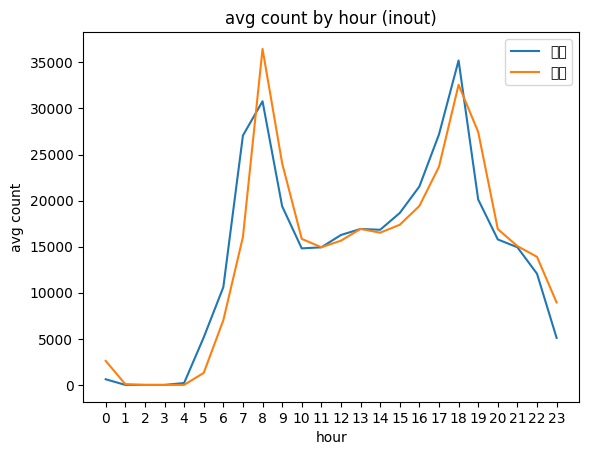

In [52]:
io=long_data.groupby(['hour','inout'])['count'].mean().reset_index()
plt.figure()
for g in io['inout'].unique():
    s=io[io['inout']==g]
    plt.plot(s['hour'],s['count'],label=g)
plt.legend()
plt.title('avg count by hour (inout)')
plt.xlabel('hour')
plt.ylabel('avg count')
plt.xticks(range(int(io['hour'].min()),int(io['hour'].max())+1))
plt.show()

In [53]:
print("size:", long_data.shape)
print("missing:\n", long_data.isna().sum())
print("hour 범위:", long_data['hour'].min(), "→", long_data['hour'].max())
print("inout 분포:\n", long_data['inout'].value_counts())
print("count 기술통계:\n", long_data['count'].describe())

size: (3654912, 6)
missing:
 사용월      0
호선명      0
지하철역     0
hour     0
inout    0
count    0
dtype: int64
hour 범위: 0 → 23
inout 분포:
 inout
승차    1827456
하차    1827456
Name: count, dtype: int64
count 기술통계:
 count    3.654912e+06
mean     1.431271e+04
std      2.297950e+04
min      0.000000e+00
25%      1.005000e+03
50%      6.961000e+03
75%      1.807500e+04
max      4.654060e+05
Name: count, dtype: float64


- 특정 시간대 운행 중단 정보와 대조하여 검증

In [54]:
s = pd.DataFrame({
    '호선명': ['1호선', '2호선', '1호선'],
    '지하철역': ['서울역', '강남', '동대문'],
    'hour': [23, 0, 1],
    'start_ym': [202001, 202105, 202211],
    'end_ym': [202012, 202106, 202301]
})

df = long_data.merge(s, on=['호선명', '지하철역', 'hour'], how='left')

df['start_ym'] = df['start_ym'].fillna(0).astype(int)
df['end_ym'] = df['end_ym'].fillna(999912).astype(int)

df['suspended'] = (df['사용월'] >= df['start_ym']) & (df['사용월'] <= df['end_ym'])

display(df.head())
display(df.dtypes)

,사용월,호선명,지하철역,hour,inout,count,start_ym,end_ym,suspended
0,202508,1호선,동대문,4,승차,396,0,999912,True
1,202508,1호선,동묘앞,4,승차,166,0,999912,True
2,202508,1호선,서울역,4,승차,672,0,999912,True
3,202508,1호선,시청,4,승차,48,0,999912,True
4,202508,1호선,신설동,4,승차,389,0,999912,True


,0
사용월,int64
호선명,object
지하철역,object
hour,int64
inout,object
count,int64
start_ym,int64
end_ym,int64
suspended,bool


In [55]:
df_filtered = df[df['hour'].isin([1,2,3,4]) == False].copy()

print("원래 데이터 크기:", df.shape)
print("필터링 후 데이터 크기:", df_filtered.shape)
display(df_filtered.head(30))

원래 데이터 크기: (3654912, 9)
필터링 후 데이터 크기: (3045760, 9)


,사용월,호선명,지하철역,hour,inout,count,start_ym,end_ym,suspended
152288,202508,1호선,동대문,5,승차,10054,0,999912,True
152289,202508,1호선,동묘앞,5,승차,2672,0,999912,True
152290,202508,1호선,서울역,5,승차,10600,0,999912,True
152291,202508,1호선,시청,5,승차,1902,0,999912,True
152292,202508,1호선,신설동,5,승차,8836,0,999912,True
152293,202508,1호선,제기동,5,승차,4974,0,999912,True
152294,202508,1호선,종각,5,승차,3825,0,999912,True
152295,202508,1호선,종로3가,5,승차,3945,0,999912,True
152296,202508,1호선,종로5가,5,승차,1849,0,999912,True
152297,202508,1호선,청량리(서울시립대입구),5,승차,10358,0,999912,True


- 이상치 탐지 및 처리(IQR, Z-score 방법 적용) (IQR: Interquartile range)

Q1: 3625.0
Q3: 21232.0
IQR: 17607.0
Lower Bound (IQR): 0
Upper Bound (IQR): 100463.5


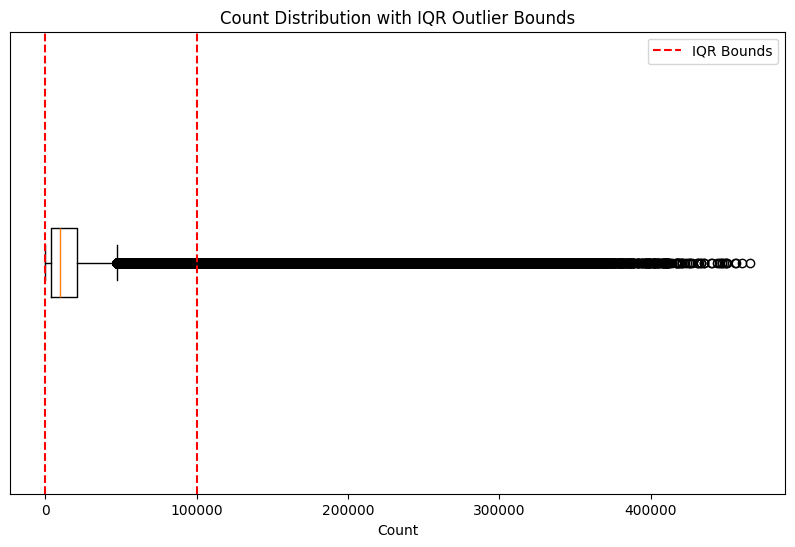

In [56]:
q1 = df_filtered['count'].quantile(0.25)
q3 = df_filtered['count'].quantile(0.75)
iqr = q3 - q1
ol = q1 - (4.5 * iqr)
ul = q3 + (4.5 * iqr)

ol = max(0, ol)

print(f"Q1: {q1}")
print(f"Q3: {q3}")
print(f"IQR: {iqr}")
print(f"Lower Bound (IQR): {ol}")
print(f"Upper Bound (IQR): {ul}")

plt.figure(figsize=(10, 6))
plt.boxplot(df_filtered['count'], vert=False, showfliers=True)
plt.vlines([ol, ul], ymin=0.5, ymax=1.5, color='r', linestyle='--', label='IQR Bounds')
plt.title('Count Distribution with IQR Outlier Bounds')
plt.xlabel('Count')
plt.yticks([])
plt.legend()
plt.show()

In [57]:
import numpy as np

outlier_mask = (abs((df_filtered['count']-np.mean(df_filtered['count']))/np.std(df_filtered['count'])))>1.96

df_cleaned = df_filtered[~outlier_mask].copy()

print("원래 df_filtered 데이터 크기:", df_filtered.shape)
print("이상치 제거 후 df_cleaned 데이터 크기:", df_cleaned.shape)

원래 df_filtered 데이터 크기: (3045760, 9)
이상치 제거 후 df_cleaned 데이터 크기: (2919531, 9)


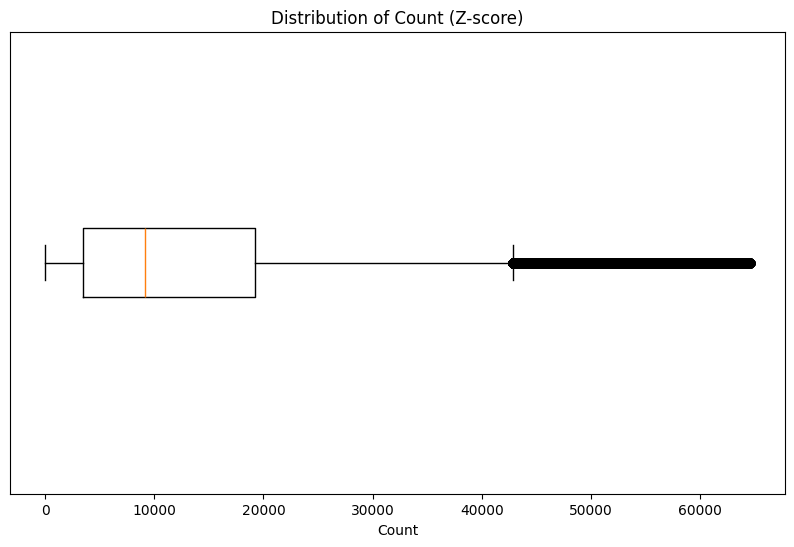

In [58]:
plt.figure(figsize=(10, 6))
plt.boxplot(df_cleaned['count'], vert=False, showfliers=True)
plt.title('Distribution of Count (Z-score)')
plt.xlabel('Count')
plt.yticks([])
plt.show()

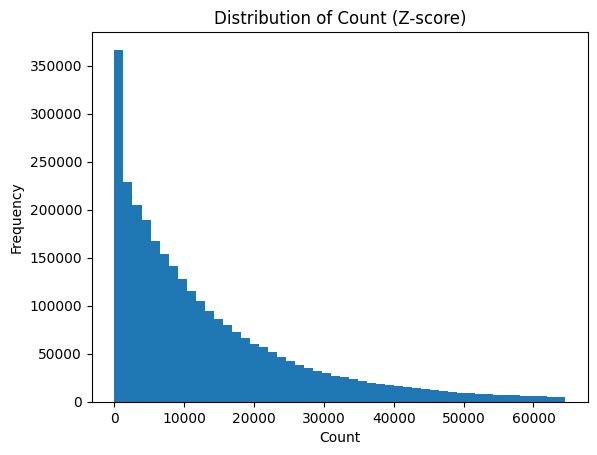

In [59]:
plt.figure()
plt.hist(df_cleaned['count'], bins=50)
plt.title('Distribution of Count (Z-score)')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

범주형 변수 인코딩

In [60]:
df_encoded = pd.get_dummies(df_cleaned, sparse=True, columns=['호선명', '지하철역'], dtype=int)

print("원래 df_cleaned 데이터 크기:", df_cleaned.shape)
print("원핫 인코딩 후 df_encoded 데이터 크기:", df_encoded.shape)
display(df_encoded.head())

원래 df_cleaned 데이터 크기: (2919531, 9)
원핫 인코딩 후 df_encoded 데이터 크기: (2919531, 635)


,사용월,hour,inout,count,start_ym,end_ym,suspended,호선명_1호선,호선명_2호선,호선명_3호선,...,지하철역_화랑대(서울여대입구),지하철역_화서,지하철역_화전,지하철역_화정,지하철역_회기,지하철역_회룡,지하철역_회현,지하철역_회현(남대문시장),지하철역_효창공원앞,지하철역_흑석(중앙대입구)
152288,202508,5,승차,10054,0,999912,True,1,0,0,...,0,0,0,0,0,0,0,0,0,0
152289,202508,5,승차,2672,0,999912,True,1,0,0,...,0,0,0,0,0,0,0,0,0,0
152290,202508,5,승차,10600,0,999912,True,1,0,0,...,0,0,0,0,0,0,0,0,0,0
152291,202508,5,승차,1902,0,999912,True,1,0,0,...,0,0,0,0,0,0,0,0,0,0
152292,202508,5,승차,8836,0,999912,True,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
import pandas as pd
import networkx as nx

df = pd.read_csv("/content/drive/MyDrive/지하철 4주 프로젝트/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv", encoding="cp949")

stations = df[['호선명','지하철역']].drop_duplicates()

edges = []
for line, group in stations.groupby('호선명'):
    stations_list = group['지하철역'].tolist()
    for i in range(len(stations_list)-1):
        edges.append((stations_list[i], stations_list[i+1]))

G = nx.Graph()
G.add_edges_from(edges)

print("노드 수:", G.number_of_nodes())
print("엣지 수:", G.number_of_edges())
print("예시 edge 20개:", edges[:20])


노드 수: 600
엣지 수: 683
예시 edge 20개: [('동대문', '동묘앞'), ('동묘앞', '서울역'), ('서울역', '시청'), ('시청', '신설동'), ('신설동', '제기동'), ('제기동', '종각'), ('종각', '종로3가'), ('종로3가', '종로5가'), ('종로5가', '청량리(서울시립대입구)'), ('청량리(서울시립대입구)', '청량리(지하)'), ('강남', '강변(동서울터미널)'), ('강변(동서울터미널)', '건대입구'), ('건대입구', '교대(법원.검찰청)'), ('교대(법원.검찰청)', '구로디지털단지'), ('구로디지털단지', '구의(광진구청)'), ('구의(광진구청)', '낙성대(강감찬)'), ('낙성대(강감찬)', '당산'), ('당산', '대림(구로구청)'), ('대림(구로구청)', '도림천'), ('도림천', '동대문역사문화공원(DDP)')]


In [62]:
df_filtered['count_clean'] = df_filtered['count'].clip(ol, ul)

print("Before:", df_filtered['count'].describe())
print("After :", df_filtered['count_clean'].describe())

Before: count    3.045760e+06
mean     1.716779e+04
std      2.418150e+04
min      0.000000e+00
25%      3.625000e+03
50%      9.746000e+03
75%      2.123200e+04
max      4.654060e+05
Name: count, dtype: float64
After : count    3.045760e+06
mean     1.645601e+04
std      1.977050e+04
min      0.000000e+00
25%      3.625000e+03
50%      9.746000e+03
75%      2.123200e+04
max      1.004635e+05
Name: count_clean, dtype: float64


In [63]:
import pandas as pd

df_enc = df_filtered.copy()

df_enc = pd.get_dummies(df_enc, columns=['호선명', 'inout'], drop_first=True)

df_enc['date'] = pd.to_datetime(df_enc['사용월'].astype(str) + '01', format='%Y%m%d')
df_enc['dow'] = df_enc['date'].dt.dayofweek

print(df_enc.head())
print("최종 컬럼:", df_enc.columns)

           사용월 지하철역  hour  count  start_ym  end_ym  suspended  count_clean  \
152288  202508  동대문     5  10054         0  999912       True      10054.0   
152289  202508  동묘앞     5   2672         0  999912       True       2672.0   
152290  202508  서울역     5  10600         0  999912       True      10600.0   
152291  202508   시청     5   1902         0  999912       True       1902.0   
152292  202508  신설동     5   8836         0  999912       True       8836.0   

        호선명_2호선  호선명_3호선  ...  호선명_수인선  호선명_신림선  호선명_안산선  호선명_우이신설선  호선명_일산선  \
152288    False    False  ...    False    False    False      False    False   
152289    False    False  ...    False    False    False      False    False   
152290    False    False  ...    False    False    False      False    False   
152291    False    False  ...    False    False    False      False    False   
152292    False    False  ...    False    False    False      False    False   

        호선명_장항선  호선명_중앙선  inout_하차       date  dow

In [64]:
df_enc['is_commute'] = ((df_enc['hour'].between(7, 9)) |
                           (df_enc['hour'].between(18, 20))).astype(int)

df_enc['is_weekend'] = (df_enc['dow'] >= 5).astype(int)

print(df_enc[['hour','dow','is_commute','is_weekend']].head(20))

        hour  dow  is_commute  is_weekend
152288     5    4           0           0
152289     5    4           0           0
152290     5    4           0           0
152291     5    4           0           0
152292     5    4           0           0
152293     5    4           0           0
152294     5    4           0           0
152295     5    4           0           0
152296     5    4           0           0
152297     5    4           0           0
152298     5    4           0           0
152299     5    4           0           0
152300     5    4           0           0
152301     5    4           0           0
152302     5    4           0           0
152303     5    4           0           0
152304     5    4           0           0
152305     5    4           0           0
152306     5    4           0           0
152307     5    4           0           0


In [65]:
df_enc['month'] = df_enc['date'].dt.month

def get_season(month):
  if month in [3,4,5]:
    return 'spring'
  elif month in [6,7,8]:
    return 'summer'
  elif month in [9,10,11]:
    return 'fall'
  else:
    return 'winter'

df_enc['season'] = df_enc['month'].apply(get_season)

print(df_enc[['date', 'month',  'season']].head(20))

             date  month  season
152288 2025-08-01      8  summer
152289 2025-08-01      8  summer
152290 2025-08-01      8  summer
152291 2025-08-01      8  summer
152292 2025-08-01      8  summer
152293 2025-08-01      8  summer
152294 2025-08-01      8  summer
152295 2025-08-01      8  summer
152296 2025-08-01      8  summer
152297 2025-08-01      8  summer
152298 2025-08-01      8  summer
152299 2025-08-01      8  summer
152300 2025-08-01      8  summer
152301 2025-08-01      8  summer
152302 2025-08-01      8  summer
152303 2025-08-01      8  summer
152304 2025-08-01      8  summer
152305 2025-08-01      8  summer
152306 2025-08-01      8  summer
152307 2025-08-01      8  summer


In [66]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

scalers = {
    "minmax": MinMaxScaler(),
    "standard": StandardScaler()
}

for name, scaler in scalers.items():
    scaled = scaler.fit_transform(df_enc[['count_clean']])
    print(f"{name} → min={scaled.min():.3f}, max={scaled.max():.3f}, mean={scaled.mean():.3f}, std={scaled.std():.3f}")

df_enc['count_log'] = np.log1p(df_enc['count_clean'])

print("\n원본 분포:", df_enc['count_clean'].describe())
print("\n로그 변환 후 분포:", df_enc['count_log'].describe())

minmax → min=0.000, max=1.000, mean=0.164, std=0.197
standard → min=-0.832, max=4.249, mean=-0.000, std=1.000

원본 분포: count    3.045760e+06
mean     1.645601e+04
std      1.977050e+04
min      0.000000e+00
25%      3.625000e+03
50%      9.746000e+03
75%      2.123200e+04
max      1.004635e+05
Name: count_clean, dtype: float64

로그 변환 후 분포: count    3.045760e+06
mean     8.812373e+00
std      1.918703e+00
min      0.000000e+00
25%      8.195885e+00
50%      9.184715e+00
75%      9.963312e+00
max      1.151756e+01
Name: count_log, dtype: float64


학습 검증 테스트 데이터 분할

**베이스라인**

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd


train = df_enc[df_enc['사용월'] < 202301].copy()
val   = df_enc[(df_enc['사용월'] >= 202301) & (df_enc['사용월'] < 202401)].copy()
test  = df_enc[df_enc['사용월'] >= 202401].copy()

le = LabelEncoder()
le.fit(train['지하철역'])

train['역코드'] = le.transform(train['지하철역'])
val['역코드']   = le.transform(val['지하철역'].map(
    lambda x: x if x in le.classes_ else le.classes_[0]
))
test['역코드']  = le.transform(test['지하철역'].map(
    lambda x: x if x in le.classes_ else le.classes_[0]
))


base_features = ['hour', 'is_commute', 'month', 'is_weekend']
line_features = [col for col in df_enc.columns if col.startswith('호선명_')]
features = base_features + line_features + ['역코드']

target = 'count_log'

X_train, y_train = train[features], train[target]
X_val, y_val     = val[features], val[target]
X_test, y_test   = test[features], test[target]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Linear Regression RMSE:", f"{rmse:,.4f}")

results = pd.DataFrame({
    "실제값": y_test[:10].values,
    "예측값": y_pred[:10]
})
print(results)

Linear Regression RMSE: 1.6547
        실제값       예측값
0  9.215825  9.172705
1  7.890957  9.172588
2  9.268704  9.170510
3  7.551187  9.169728
4  9.086703  9.169429
5  8.512181  9.167050
6  8.249575  9.167017
7  8.280458  9.167001
8  7.522941  9.166984
9  9.245611  9.166452


In [68]:
X_train[:10]

,hour,is_commute,month,is_weekend,호선명_2호선,호선명_3호선,호선명_4호선,호선명_5호선,호선명_6호선,호선명_7호선,...,호선명_분당선,호선명_서해선,호선명_수인선,호선명_신림선,호선명_안산선,호선명_우이신설선,호선명_일산선,호선명_장항선,호선명_중앙선,역코드
172093,5,0,12,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,152
172094,5,0,12,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,159
172095,5,0,12,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,284
172096,5,0,12,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,331
172097,5,0,12,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,349
172098,5,0,12,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,492
172099,5,0,12,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,494
172100,5,0,12,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,495
172101,5,0,12,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,496
172102,5,0,12,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,528


딥러닝 모델

In [69]:
# 0) 안전복사 + 불리언 -> int8 변환
X_train = X_train.copy(); X_val = X_val.copy(); X_test = X_test.copy()
for df_ in (X_train, X_val, X_test):
    bool_cols = df_.select_dtypes(include=["bool"]).columns
    for c in bool_cols:
        df_[c] = df_[c].astype("int8")

# 1) 수치 컬럼 표준화(MLP 안정화)
from sklearn.preprocessing import StandardScaler
num_cols = X_train.select_dtypes(include=["int64","float64","int32","float32"]).columns
sc = StandardScaler()
X_train[num_cols] = sc.fit_transform(X_train[num_cols])
X_val[num_cols]   = sc.transform(X_val[num_cols])
X_test[num_cols]  = sc.transform(X_test[num_cols])

# 2) 넘파이 float32로 (GPU/속도 안정)
X_train_np = X_train.values.astype("float32")
y_train_np = y_train.values.astype("float32")
X_val_np   = X_val.values.astype("float32")
y_val_np   = y_val.values.astype("float32")
X_test_np  = X_test.values.astype("float32")
y_test_np  = y_test.values.astype("float32")

# 3) 간단 MLP
import tensorflow as tf
from tensorflow.keras import Sequential, layers, callbacks, optimizers

model = Sequential([
    layers.Input(shape=(X_train_np.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(1),
])

opt = optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=opt, loss="mse")

cbs = [
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
]

history = model.fit(
    X_train_np, y_train_np,
    epochs=18, batch_size=512,
    validation_data=(X_val_np, y_val_np),
    callbacks=cbs, verbose=1
)

# 4) 평가 (로그/원단위)
from sklearn.metrics import mean_squared_error
y_pred_log = model.predict(X_test_np, batch_size=2048).ravel()
rmse_log = float(np.sqrt(mean_squared_error(y_test_np, y_pred_log)))

y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_np)
rmse_cnt = float(np.sqrt(np.mean((y_pred - y_true)**2)))

print(f"log-RMSE: {rmse_log:.3f} | RMSE(count): {rmse_cnt:,.0f}")

Epoch 1/18
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 20.8869 - val_loss: 2.1607 - learning_rate: 3.0000e-04
Epoch 2/18
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 2.1102 - val_loss: 1.9859 - learning_rate: 3.0000e-04
Epoch 3/18
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 1.9232 - val_loss: 1.7919 - learning_rate: 3.0000e-04
Epoch 4/18
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 1.7683 - val_loss: 1.7123 - learning_rate: 3.0000e-04
Epoch 5/18
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 1.6942 - val_loss: 1.6593 - learning_rate: 3.0000e-04
Epoch 6/18
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 64s 7ms/step - loss: 1.6454 - val_loss: 1.6210 - learning_rate: 3.0000e-04
Epoch 7/18
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - loss: 1.6063 - val_loss: 1.5941 - learning_rate: 3.0000e-04
Epoch 8/18
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 1.5726 - val_loss: 1.5556 - learning_rate: 3.0000e-04
Epoch 9/18
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss:

In [70]:
import numpy as np, tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

X_train_lstm = np.expand_dims(np.asarray(X_train, dtype=np.float32), 1)
X_val_lstm   = np.expand_dims(np.asarray(X_val,   dtype=np.float32), 1)
X_test_lstm  = np.expand_dims(np.asarray(X_test,  dtype=np.float32), 1)

y_train_arr = np.asarray(y_train, dtype=np.float32)
y_val_arr   = np.asarray(y_val,   dtype=np.float32)
y_test_arr  = np.asarray(y_test,  dtype=np.float32)

In [71]:
model_lstm = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [72]:
import pickle
model.save("my_lstm_model.keras")

In [73]:
val_loss,  val_rmse  = model_lstm.evaluate(X_val_lstm,  y_val_arr,  verbose=0)
test_loss, test_rmse = model_lstm.evaluate(X_test_lstm, y_test_arr, verbose=0)
print("VAL RMSE(log):", round(val_rmse,4))
print("TEST RMSE(log):", round(test_rmse,4))

pred_test_log = model_lstm.predict(X_test_lstm, batch_size=4096).ravel()
pred_test_cnt = np.expm1(pred_test_log).clip(min=0)
y_test_cnt    = np.expm1(y_test_arr).clip(min=0)
rmse_cnt = float(np.sqrt(np.mean((pred_test_cnt - y_test_cnt)**2)))
print("TEST RMSE(count):", f"{rmse_cnt:,.0f}")

VAL RMSE(log): 8.9952
TEST RMSE(log): 9.0128
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
TEST RMSE(count): 25,179


In [74]:
import numpy as np, pandas as pd

# 검증셋 예측(log) → count 변환
pred_val_log = model_lstm.predict(X_val_lstm, batch_size=4096, verbose=0).ravel()
y_val_cnt = np.expm1(y_val_arr).clip(min=0)
p_val_cnt = np.expm1(pred_val_log).clip(min=0)

# 전역 배율(총량 보정)
k_global = float(y_val_cnt.sum() / max(p_val_cnt.sum(), 1e-9))

# 시간대별 배율(과도한 보정 방지 clip)
meta_val = df_filtered.loc[val.index, ['hour']].copy()
k_hour = (
    pd.DataFrame({'h': meta_val['hour'].to_numpy(), 'y': y_val_cnt, 'p': p_val_cnt})
      .groupby('h')
      .apply(lambda g: (g.y.sum()/g.p.sum()) if g.p.sum()>0 else 1.0)
      .clip(0.6, 1.8)
)
print("k_global:", round(k_global, 4))
print("k_hour (head):")
print(k_hour.head())

k_global: 907419.4375
k_hour (head):
h
0    1.8
5    1.8
6    1.8
7    1.8
8    1.8
dtype: float32


/tmp/ipython-input-3063103881.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g.y.sum()/g.p.sum()) if g.p.sum()>0 else 1.0)


In [109]:
den = float((df_val["p"] * df_val["hour"].map(k_hour).fillna(1.0)).sum())
k_global = float(df_val["y"].sum() / max(den, 1e-9))


out["pred_cal"] = out["pred_raw"] * k_global * out["hour"].map(k_hour).fillna(1.0)

In [110]:
import numpy as np, pandas as pd


dfh = (
    df_val.groupby("hour", as_index=False)
          .agg(y_sum=("y","sum"), p_sum=("p","sum"), n=("y","size"))
)

# 1) 저유량 시간 제외(예: y 또는 p 합이 너무 작으면 안정적 추정 불가)
MIN_VOL = 3_000.0
mask = (dfh["y_sum"] >= MIN_VOL) & (dfh["p_sum"] >= MIN_VOL)

# 2) 기본 비율
dfh["k_raw"] = dfh["y_sum"] / dfh["p_sum"].clip(lower=1e-9)

# 3) 1로 수축 (관측이 적을수록 1에 가깝게)
#    weight = n / (n + alpha)  ; alpha 는 수축 강도 (값 클수록 더 1로 당김)
ALPHA = 500.0
w = dfh["n"] / (dfh["n"] + ALPHA)
dfh["k_shrunk"] = 1.0 + w * (dfh["k_raw"] - 1.0)

# 4) 보수적 클리핑 (야간 폭주 방지)
LOW, HIGH = 0.8, 1.25
dfh["k_safe"] = dfh["k_shrunk"].clip(LOW, HIGH)

# 5) 저유량 시간은 1.0으로 강제
dfh.loc[~mask, "k_safe"] = 1.0

# 6) 새 시간별 스케일 맵
k_hour = pd.Series(dfh.set_index("hour")["k_safe"]).astype(float)

print("Rebuilt k_hour with shrinkage/clip.")
print(dfh[["hour","y_sum","p_sum","n","k_raw","k_shrunk","k_safe"]].head(24))

# 7) 재보정 적용
out["pred_cal"] = out["pred_raw"] * float(k_global) * out["hour"].map(k_hour).fillna(1.0)

Rebuilt k_hour with shrinkage/clip.
    hour        y_sum         p_sum     n       k_raw    k_shrunk    k_safe
0      0   16471404.0  1.986684e+07  5549    0.829090    0.843218  0.843218
1      1     395428.0  3.104686e+03  5549  127.364891  116.919785  1.250000
2      2       1106.0  7.432414e+02  5549    1.488076    1.447733  1.000000
3      3         29.0  4.879501e+02  5549    0.059432    0.137178  1.000000
4      4    1363984.0  1.197648e+05  5549   11.388854   10.530129  1.250000
5      5   36652148.0  1.976721e+07  5549    1.854189    1.783584  1.250000
6      6   99933872.0  4.892191e+07  5549    2.042722    1.956533  1.250000
7      7  235520560.0  1.657599e+08  5549    1.420853    1.386066  1.250000
8      8  359713504.0  1.931743e+08  5549    1.862119    1.790858  1.250000
9      9  236325776.0  2.650003e+08  5549    0.891794    0.900738  0.900738
10    10  170631408.0  1.897166e+08  5549    0.899402    0.907717  0.907717
11    11  166036528.0  1.292703e+08  5549    1.28441

In [83]:
# 테스트셋 예측(log) → count
pred_test_log = model_lstm.predict(X_test_lstm, batch_size=4096, verbose=0).ravel()
pred_test_cnt = np.expm1(pred_test_log).clip(min=0)
y_test_cnt = np.expm1(y_test_arr).clip(min=0)

# 메타(사용월/호선명/지하철역/hour) 붙이기
meta_test = df_filtered.loc[test.index, ['사용월','호선명','지하철역','hour']].copy()

out = meta_test.copy()
out['congestion'] = y_test_cnt.astype(int)
out['pred_raw']   = pred_test_cnt

# 원본 RMSE(count)
rmse_raw = float(np.sqrt(np.mean((out['congestion'] - out['pred_raw'])**2)))
print("TEST RMSE(count) naive:", f"{rmse_raw:,.0f}")

TEST RMSE(count) naive: 25,178


In [84]:
out['pred_cal'] = out['pred_raw'] * k_global * out['hour'].map(k_hour).fillna(1.0)

rmse_cal = float(np.sqrt(np.mean((out['congestion'] - out['pred_cal'])**2)))
print("TEST RMSE(count) calibrated:", f"{rmse_cal:,.0f}")

print(
    out.query("지하철역=='동대문' and 사용월==202410")
       .sort_values('hour')
       .head(15)
)

TEST RMSE(count) calibrated: 47,348
            사용월  호선명 지하철역  hour  congestion  pred_raw  pred_cal
3128215  202410  4호선  동대문     0        1546       0.0       0.0
3128117  202410  1호선  동대문     0        2838       0.0       0.0
3052071  202410  4호선  동대문     0        1405       0.0       0.0
3051973  202410  1호선  동대문     0         770       0.0       0.0
158501   202410  1호선  동대문     5       12458       0.0       0.0
158599   202410  4호선  동대문     5        4931       0.0       0.0
234645   202410  1호선  동대문     5        1989       0.0       0.0
234743   202410  4호선  동대문     5        2428       0.0       0.0
310789   202410  1호선  동대문     6       10170       0.0       0.0
310887   202410  4호선  동대문     6        3326       0.0       0.0
386933   202410  1호선  동대문     6        7252       0.0       0.0
387031   202410  4호선  동대문     6       15229       0.0       0.0
463077   202410  1호선  동대문     7       16815       0.0       0.0
463175   202410  4호선  동대문     7        5485       0.0       0.0
5392

In [85]:
import os, datetime as dt

save_dir = globals().get('FOLDER', '/content')
fname = f"lstm_results_{dt.datetime.now():%Y%m%d_%H%M%S}.csv"
out_path = os.path.join(save_dir, fname)

out[['사용월','호선명','지하철역','hour','congestion','pred_raw','pred_cal']].to_csv(out_path, index=False, encoding='utf-8-sig')
print("Saved:", out_path)

Saved: /content/drive/MyDrive/지하철 4주 프로젝트/lstm_results_20251021_102913.csv


데이터 로드 + 피쳐

In [86]:
need_cols = {"사용월","호선명","지하철역","hour","congestion"}
miss = need_cols - set(agg.columns)
if miss:
    raise ValueError(f"agg에 필요한 컬럼이 없습니다: {miss}")

agg = agg.copy()
agg["congestion_log"] = np.log1p(agg["congestion"])
agg["month"] = agg["사용월"] % 100
agg["m_sin"]  = np.sin(2*np.pi*(agg["month"]-1)/12)
agg["m_cos"]  = np.cos(2*np.pi*(agg["month"]-1)/12)
agg["is_commute"] = ((agg["hour"].between(7,9)) | (agg["hour"].between(17,19))).astype("int8")

시퀸스 윈도우

In [87]:
def make_seq(df, win=6, y_col="congestion_log"):
    df2 = df.sort_values(["호선명","지하철역","hour","사용월"]).copy()
    feats = ["hour","m_sin","m_cos","is_commute"]
    X_list, y_list, meta_list = [], [], []
    for (line, st, h), g in df2.groupby(["호선명","지하철역","hour"], sort=False):
        g = g[["사용월"] + feats + [y_col]].to_numpy()
        if len(g) < win+1:
            continue
        for i in range(len(g)-win):
            X_list.append(g[i:i+win, 1:-1])      # (win, F)
            y_list.append(g[i+win, -1])          # 다음 시점 y (log)
            meta_list.append((int(g[i+win,0]), line, st, int(h)))
    if not X_list:
        return (np.empty((0,win,len(feats)),dtype="float32"),
                np.empty((0,),dtype="float32"),
                pd.DataFrame(columns=["사용월","호선명","지하철역","hour"]))
    X = np.array(X_list, dtype="float32")
    y = np.array(y_list, dtype="float32")
    meta = pd.DataFrame(meta_list, columns=["사용월","호선명","지하철역","hour"])
    return X, y, meta

기간 분할

In [88]:
WIN = 6
X_all, y_all, meta_all = make_seq(agg, win=WIN, y_col="congestion_log")

tr = meta_all["사용월"] <= 202312                  # 2023년까지 학습
va = meta_all["사용월"].between(202401, 202409)     # 2024-01~09 검증
te = meta_all["사용월"] >= 202410                  # 2024-10~ 테스트

X_tr, y_tr, meta_tr = X_all[tr], y_all[tr], meta_all[tr].reset_index(drop=True)
X_va, y_va, meta_va = X_all[va], y_all[va], meta_all[va].reset_index(drop=True)
X_te, y_te, meta_te = X_all[te], y_all[te], meta_all[te].reset_index(drop=True)

print("X shapes  ->", X_tr.shape, X_va.shape, X_te.shape)
print("y shapes  ->", y_tr.shape, y_va.shape, y_te.shape)
print(meta_te.head())

X shapes  -> (1426224, 6, 4) (133176, 6, 4) (163560, 6, 4)
y shapes  -> (1426224,) (133176,) (163560,)
      사용월  호선명 지하철역  hour
0  202410  1호선  동대문     0
1  202411  1호선  동대문     0
2  202412  1호선  동대문     0
3  202501  1호선  동대문     0
4  202502  1호선  동대문     0


In [89]:
import numpy as np

def _to_float32(*arrs):
    return [np.asarray(a, dtype=np.float32) for a in arrs]

def _ensure_3d(x):
    if x.ndim == 2:
        x = np.expand_dims(x, axis=1)
    return x

X_tr, y_tr = _to_float32(X_tr, y_tr)
X_va, y_va = _to_float32(X_va, y_va)
X_te, y_te = _to_float32(X_te, y_te)

X_tr = _ensure_3d(X_tr); X_va = _ensure_3d(X_va); X_te = _ensure_3d(X_te)
T, F = X_tr.shape[1], X_tr.shape[2]
INPUT_SHAPE = (T, F)

준비 & 배열/배치 안전장치

In [90]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def fit_eval(model, name, epochs=20, bs=512, lr=3e-4):
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    hist = model.fit(X_tr, y_tr, epochs=epochs, batch_size=bs,
                     validation_data=(X_va, y_va), verbose=1)

    v_loss, v_rmse = model.evaluate(X_va, y_va, verbose=0)
    t_loss, t_rmse = model.evaluate(X_te, y_te, verbose=0)

    p_log = model.predict(X_te, batch_size=4096, verbose=0).ravel()
    p = np.expm1(p_log); g = np.expm1(y_te)
    r = float(np.sqrt(np.mean((p - g)**2)))

    out = meta_te.copy(); out["congestion"] = g.astype(int); out["pred"] = p
    print(f"[{name}] VAL RMSE(log): {v_rmse:.4f} | TEST RMSE(log): {t_rmse:.4f} | TEST RMSE(cnt): {r:,.0f}")
    return out, model, v_rmse, t_rmse, r, hist



GRU (RNN + better memory)

In [91]:
EPOCHS = 6
BS     = 512
INPUT_SHAPE = X_tr.shape[1:]  # (T, F)

gru = models.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.GRU(128, return_sequences=True, dropout=0.1),
    layers.GRU(64, dropout=0.1),
    # 시퀀스 출력 안정화
    layers.LayerNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

opt = optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
gru.compile(
    optimizer=opt,
    # heavy-tail/아웃라이어에 더 강하게: Huber
    loss=tf.keras.losses.Huber(delta=0.5),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)

cbs = [
    callbacks.ReduceLROnPlateau(monitor="val_rmse", mode="min", factor=0.5, patience=2, verbose=1),
    callbacks.EarlyStopping(monitor="val_rmse", mode="min", patience=4, restore_best_weights=True, verbose=1)
]

hist_gru = gru.fit(
    X_tr, y_tr,
    epochs=EPOCHS, batch_size=BS,
    validation_data=(X_va, y_va),
    shuffle=True,
    callbacks=cbs,
    verbose=1
)

val_loss, val_rmse = gru.evaluate(X_va, y_va, verbose=0)
test_loss, test_rmse = gru.evaluate(X_te, y_te, verbose=0)
print(f"[GRU] VAL RMSE(log): {val_rmse:.4f} | TEST RMSE(log): {test_rmse:.4f}")

Epoch 1/6
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.5553 - rmse: 2.2049 - val_loss: 0.4317 - val_rmse: 1.7829 - learning_rate: 0.0010
Epoch 2/6
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 0.4582 - rmse: 1.9347 - val_loss: 0.4039 - val_rmse: 1.7022 - learning_rate: 0.0010
Epoch 3/6
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 0.4563 - rmse: 1.9328 - val_loss: 0.3983 - val_rmse: 1.6990 - learning_rate: 0.0010
Epoch 4/6
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.4570 - rmse: 1.9371 - val_loss: 0.4055 - val_rmse: 1.7222 - learning_rate: 0.0010
Epoch 5/6
2780/2786 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4553 - rmse: 1.9307
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 0.4553 - rmse: 1.9307 - val_loss: 0.4795 - val_rmse: 1.9355 - learning_rate: 0.0010
Epoch 6/6
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.4550 - rmse: 1.9318 - val_loss: 0.4542 - val_rmse: 1.8575

1D - CNN

In [92]:
# import os, time
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers
# from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# EPOCHS = 12
# BATCH  = 64
# LR     = 3e-4

# INPUT_SHAPE = X_tr.shape[1:]

# # --- 모델 정의 ---
# def build_1dcnn(input_shape):
#     m = models.Sequential([
#         layers.Input(shape=input_shape),
#         layers.Conv1D(64, 3, padding="causal", activation="relu"),
#         layers.Conv1D(64, 3, padding="causal", activation="relu"),
#         layers.GlobalAveragePooling1D(),
#         layers.Dense(32, activation="relu"),
#         layers.Dense(1)
#     ])
#     return m

# model = build_1dcnn(INPUT_SHAPE)

# # --- 콜백 ---
# RLP  = ReduceLROnPlateau(monitor='val_rmse', mode='min',
#                          factor=0.5, patience=2, min_delta=1e-3,
#                          min_lr=1e-5, verbose=1)
# ckpt_path = 'best_1dcnn.keras'
# CKPT = ModelCheckpoint(filepath=ckpt_path, monitor='val_rmse', mode='min',
#                        save_best_only=True, verbose=1)

# # --- 컴파일 ---
# model.compile(
#     optimizer=optimizers.Adam(LR),
#     loss='mse',
#     metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
# )

# # --- 학습 ---
# hist = model.fit(
#     X_tr, y_tr,
#     epochs=EPOCHS, batch_size=BATCH,
#     validation_data=(X_va, y_va),
#     callbacks=[RLP, CKPT],
#     verbose=1, shuffle=True
# )

# # --- 평가 ---
# val_loss, val_rmse = model.evaluate(X_va, y_va, verbose=0)
# test_loss, test_rmse = model.evaluate(X_te, y_te, verbose=0)
# print(f"[1D-CNN] VAL RMSE(log): {val_rmse:.4f} | TEST RMSE(log): {test_rmse:.4f}")

# # --- 예측 (로그 → 원스케일) ---
# p_log = model.predict(X_te, batch_size=4096, verbose=0).ravel()
# p_cnt = np.expm1(p_log).clip(min=0)
# y_cnt = np.expm1(y_te).clip(min=0)
# rmse_cnt = float(np.sqrt(np.mean((p_cnt - y_cnt)**2)))
# print(f"[1D-CNN] TEST RMSE(count): {rmse_cnt:,.0f}")

# # --- 결과 DF (meta_te가 있으면 메타 붙이고, 없으면 기본 인덱스만) ---
# try:
#     out_cnn = meta_te.copy()
#     out_cnn["congestion"] = y_cnt.astype(int)
#     out_cnn["pred_raw"]   = p_cnt
# except NameError:
#     out_cnn = pd.DataFrame({
#         "congestion": y_cnt.astype(int),
#         "pred_raw": p_cnt
#     })

# # --- 간단 캘리브레이션 (합계 보정; 원치 않으면 주석 처리) ---
# ratio = (out_cnn["congestion"].sum() / out_cnn["pred_raw"].sum()) if out_cnn["pred_raw"].sum() > 0 else 1.0
# out_cnn["pred_cal"] = out_cnn["pred_raw"] * ratio
# rmse_cnt_cal = float(np.sqrt(np.mean((out_cnn["pred_cal"].to_numpy() - out_cnn["congestion"].to_numpy())**2)))
# print(f"[1D-CNN] TEST RMSE(count) calibrated: {rmse_cnt_cal:,.0f}")

# # --- 저장 ---
# ts = time.strftime("%Y%m%d_%H%M%S")
# csv_path = f"final_results_1D-CNN_{ts}.csv"
# out_cnn.to_csv(csv_path, index=False, encoding="utf-8-sig")
# print("Saved CSV ->", csv_path)

# # 베스트 가중치 / 최종 모델 저장
# print("Best weights saved at:", ckpt_path)
# final_model_path = f"cnn1d_final_{ts}.keras"
# model.save(final_model_path)
# print("Saved Model ->", final_model_path)

# # --- 샘플 출력 (메타 있으면 특정 역/기간 확인; 없으면 상위 10행) ---
# try:
#     print(out_cnn.query("지하철역=='동대문' and 사용월==202410").head(15))
# except Exception:
#     print(out_cnn.head(10))

LSTM

In [93]:
# import numpy as np, tensorflow as tf
# from tensorflow.keras import layers, models, callbacks, optimizers

# assert X_tr.ndim==3 and X_va.ndim==3 and X_te.ndim==3
# INPUT_SHAPE = X_tr.shape[1:]

# lstm = models.Sequential([
#     layers.Input(shape=INPUT_SHAPE),
#     layers.LSTM(64, return_sequences=False),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1)
# ])

# lstm.compile(
#     optimizer=optimizers.Adam(3e-4),
#     loss="mse",
#     metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
# )

# ES  = callbacks.EarlyStopping(monitor="val_rmse", mode="min",
#                               patience=3, restore_best_weights=True, verbose=1)
# RLP = callbacks.ReduceLROnPlateau(monitor="val_rmse", mode="min",
#                                   factor=0.5, patience=2, min_lr=1e-5, verbose=1)

# hist = lstm.fit(X_tr, y_tr,
#                 epochs=10, batch_size=64,
#                 validation_data=(X_va, y_va),
#                 callbacks=[ES, RLP], verbose=1)

# v_loss, v_rmse = lstm.evaluate(X_va, y_va, verbose=0)
# t_loss, t_rmse = lstm.evaluate(X_te, y_te, verbose=0)
# print(f"[LSTM] VAL RMSE(log): {v_rmse:.4f} | TEST RMSE(log): {t_rmse:.4f}")

검증셋 기반 켈리브레이션 계수 추정 셀

In [94]:
import numpy as np, pandas as pd

def safe_calibrate(model, X_val, y_val, X_test, meta_val_hours, meta_test):
    # 1) 검증셋 예측(log -> count)
    p_val = np.expm1(model.predict(X_val, batch_size=4096, verbose=0).ravel()).clip(min=0)
    y_val_c = np.expm1(y_val).clip(min=0)

    y_sum, p_sum = float(y_val_c.sum()), float(p_val.sum())
    if p_sum < 1e-3:
        print("[CAL] skip: validation prediction sum ~ 0")
        k_global = 1.0
        k_hour   = None
    else:
        k_global = np.clip(y_sum / p_sum, 0.8, 1.2)  # 온건한 합계 보정
        df = pd.DataFrame({'h': meta_val_hours.to_numpy(), 'y': y_val_c, 'p': p_val})
        gp = df.groupby('h', sort=True)[['y','p']].sum()
        k_hour = ((gp['y']+1.0) / (gp['p']+1.0)).clip(0.7, 1.4)  # 안정화

    # 2) 테스트 예측
    p_test = np.expm1(model.predict(X_test, batch_size=4096, verbose=0).ravel()).clip(min=0)

    out = meta_test.reset_index(drop=True).copy()
    out['pred_raw'] = p_test

    if k_hour is None:
        out['pred_cal'] = out['pred_raw']  # 보정 스킵
    else:
        out['pred_cal'] = out['pred_raw'] * k_global * out['hour'].map(k_hour).fillna(1.0)

    return out, k_global, k_hour

# GRU에 적용
out_gru_cal, k_g, k_h = safe_calibrate(gru, X_va, y_va, X_te, meta_va['hour'], meta_te)

# RMSE(count) 확인
y_cnt = np.expm1(y_te).clip(min=0)
rmse_raw = float(np.sqrt(np.mean((out_gru_cal['pred_raw'] - y_cnt)**2)))
rmse_cal = float(np.sqrt(np.mean((out_gru_cal['pred_cal'] - y_cnt)**2)))
print(f"[GRU] TEST RMSE(count) raw={rmse_raw:,.0f}  |  calibrated={rmse_cal:,.0f}")

[GRU] TEST RMSE(count) raw=37,920  |  calibrated=35,591


보정계수 (a,b) 추정

In [95]:
import numpy as np, pandas as pd

# 검증셋 예측(log→count)
p_val_log = gru.predict(X_va, batch_size=4096, verbose=0).ravel()
p_val = np.expm1(p_val_log).clip(min=0)
y_val = np.expm1(y_va).clip(min=0)

# 전역 선형 보정계수 y ≈ a*p + b (비음수로 클립)
x = p_val; y = y_val
vx = x - x.mean(); vy = y - y.mean()
den = float((vx**2).mean()) + 1e-12
a = float((vx*vy).mean() / den)
b = float(y.mean() - a*x.mean())
a = max(a, 0.0); b = max(b, 0.0)
print(f"a={a:.4f}, b={b:.2f}")

a=1.1724, b=4246.71


보정 적용 + 최종 RMSE계산 셀

In [96]:
# 테스트셋 예측(log→count)
p_test_log = gru.predict(X_te, batch_size=4096, verbose=0).ravel()
p_test = np.expm1(p_test_log).clip(min=0)
y_test = np.expm1(y_te).clip(min=0)

# 결과 프레임
out = meta_te.copy()
out["congestion"] = y_test.astype(int)
out["pred_raw"]   = p_test

# 보정 적용
out["pred_cal"] = np.maximum(0.0, a*out["pred_raw"] + b)

# (선택) 총량 정렬(미세 맞춤)
ratio = out["congestion"].sum() / max(out["pred_cal"].sum(), 1e-9)
out["pred_cal"] *= ratio

# 지표
def rmse(y,p):
    y=np.asarray(y,float); p=np.asarray(p,float)
    return float(np.sqrt(np.mean((y-p)**2)))

rmse_raw = rmse(out["congestion"], out["pred_raw"])
rmse_cal = rmse(out["congestion"], out["pred_cal"])
sum_ratio = float(out["pred_cal"].sum() / (out["congestion"].sum()+1e-9))

print(f"TEST RMSE(count) raw       : {rmse_raw:,.0f}")
print(f"TEST RMSE(count) calibrated: {rmse_cal:,.0f}")
print(f"Sum ratio pred/actual      : {sum_ratio:.3f}")

# 저장
out[["사용월","호선명","지하철역","hour","congestion","pred_raw","pred_cal"]] \
  .to_csv("final_gru_calibrated_results.csv", index=False, encoding="utf-8-sig")
print("Saved: final_gru_calibrated_results.csv")

TEST RMSE(count) raw       : 37,920
TEST RMSE(count) calibrated: 36,940
Sum ratio pred/actual      : 1.000
Saved: final_gru_calibrated_results.csv


In [97]:
import numpy as np, pandas as pd
from sklearn.metrics import r2_score

def metrics_for(y_true_cnt, y_pred_cnt):
    y = np.asarray(y_true_cnt, dtype=float)
    p = np.asarray(y_pred_cnt, dtype=float)
    rmse  = float(np.sqrt(np.mean((y - p)**2)))
    mae   = float(np.mean(np.abs(y - p)))
    r2    = float(r2_score(y, p))
    smape = float(100.0 * np.mean(2.0*np.abs(p - y) / (np.abs(y) + np.abs(p) + 1e-9)))
    return {"RMSE": rmse, "MAE": mae, "R2": r2, "SMAPE(%)": smape}

# 1) 전체 성능: raw vs calibrated
y     = out["congestion"].to_numpy()
p_raw = out["pred_raw"].to_numpy()
p_cal = out["pred_cal"].to_numpy()

print("RAW :", metrics_for(y, p_raw))
print("CAL :", metrics_for(y, p_cal))

# 2) 출퇴근 시간대(7–9, 18–20)
mask_commute = out["hour"].between(7,9) | out["hour"].between(18,20)
print("CAL | Commute hours:", metrics_for(y[mask_commute], p_cal[mask_commute]))

# 3) 특정 역(예: 역삼)
mask_yeoksam = (out["지하철역"] == "역삼")
print("CAL | Yeoksam:", metrics_for(y[mask_yeoksam], p_cal[mask_yeoksam]))

# 4) 총량 정합 체크 (캘리브레이션 품질)
sum_ratio_raw = float(p_raw.sum() / max(y.sum(), 1e-9))
sum_ratio_cal = float(p_cal.sum() / max(y.sum(), 1e-9))
print(f"Sum ratio (pred/actual): raw={sum_ratio_raw:.3f} → cal={sum_ratio_cal:.3f}")



RAW : {'RMSE': 37920.344801106134, 'MAE': 19563.227218161872, 'R2': 0.11249972964441457, 'SMAPE(%)': 91.93755493793738}
CAL : {'RMSE': 36939.78219477425, 'MAE': 21597.768317899754, 'R2': 0.15780511468730463, 'SMAPE(%)': 97.51216519413215}
CAL | Commute hours: {'RMSE': 53967.488298468146, 'MAE': 35964.146739919604, 'R2': -0.054951806927656, 'SMAPE(%)': 76.87411906457885}
CAL | Yeoksam: {'RMSE': 134728.2378398996, 'MAE': 94354.97338312323, 'R2': -0.5011769056781319, 'SMAPE(%)': 120.09158146618131}
Sum ratio (pred/actual): raw=0.712 → cal=1.000


켈리브레이션 파이프라인 통합

In [98]:
import numpy as np, pandas as pd, time
from sklearn.metrics import r2_score

def rmse_np(y, p):
    y = np.asarray(y, float); p = np.asarray(p, float)
    return float(np.sqrt(np.mean((y - p)**2)))
def mae_np(y, p):
    y = np.asarray(y, float); p = np.asarray(p, float)
    return float(np.mean(np.abs(y - p)))
def r2_np(y, p):
    return float(r2_score(np.asarray(y, float), np.asarray(p, float)))
def smape_percent(y, p):
    y = np.asarray(y, float); p = np.asarray(p, float)
    denom = np.abs(y) + np.abs(p)
    mask = denom > 0
    return float((200.0 * np.abs(y[mask] - p[mask]) / denom[mask]).mean()) if mask.any() else np.nan

In [99]:
pred_val_log = gru.predict(X_va, batch_size=4096, verbose=0).ravel()
p_val_cnt = np.expm1(pred_val_log).clip(min=0)
y_val_cnt = np.expm1(y_va).clip(min=0)

k_global = float(y_val_cnt.sum() / max(p_val_cnt.sum(), 1e-9))

df_val = pd.DataFrame({
    "hour": meta_va["hour"].to_numpy(),
    "y": y_val_cnt,
    "p": p_val_cnt
})
k_hour = df_val.groupby("hour").apply(lambda g: (g["y"].sum()/g["p"].sum()) if g["p"].sum()>0 else 1.0)
k_hour = k_hour.clip(lower=0.6, upper=1.8).astype(float)  # 안정 클립

print(f"[Calib] k_global={k_global:.4f}  | hours learned={len(k_hour)}")

[Calib] k_global=1.3822  | hours learned=24


/tmp/ipython-input-3481056080.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  k_hour = df_val.groupby("hour").apply(lambda g: (g["y"].sum()/g["p"].sum()) if g["p"].sum()>0 else 1.0)


In [100]:
res_raw = {
    "RMSE": rmse_np(out["congestion"], out["pred_raw"]),
    "MAE":  mae_np(out["congestion"], out["pred_raw"]),
    "R2":   r2_np(out["congestion"],  out["pred_raw"]),
    "SMAPE(%)": smape_percent(out["congestion"], out["pred_raw"]),
}
res_cal = {
    "RMSE": rmse_np(out["congestion"], out["pred_cal"]),
    "MAE":  mae_np(out["congestion"], out["pred_cal"]),
    "R2":   r2_np(out["congestion"],  out["pred_cal"]),
    "SMAPE(%)": smape_percent(out["congestion"], out["pred_cal"]),
}
sum_ratio_raw = out["pred_raw"].sum() / max(out["congestion"].sum(), 1e-9)
sum_ratio_cal = out["pred_cal"].sum() / max(out["congestion"].sum(), 1e-9)

print("\n== Overall Test Metrics ==")
print("RAW :", res_raw)
print("CAL :", res_cal)
print(f"Sum ratio (pred/actual): raw={sum_ratio_raw:.3f} → cal={sum_ratio_cal:.3f}")



== Overall Test Metrics ==
RAW : {'RMSE': 37920.344801106134, 'MAE': 19563.227218161872, 'R2': 0.11249972964441457, 'SMAPE(%)': 91.93755509588256}
CAL : {'RMSE': 36939.78219477425, 'MAE': 21597.768317899754, 'R2': 0.15780511468730463, 'SMAPE(%)': 97.51216519414147}
Sum ratio (pred/actual): raw=0.712 → cal=1.000


In [101]:
commute_mask = out["hour"].between(7,9) | out["hour"].between(17,19)
if commute_mask.any():
    comm = out[commute_mask]
    print("\nCAL | Commute hours:", {
        "RMSE": rmse_np(comm["congestion"], comm["pred_cal"]),
        "MAE":  mae_np(comm["congestion"], comm["pred_cal"]),
        "R2":   r2_np(comm["congestion"],  comm["pred_cal"]),
        "SMAPE(%)": smape_percent(comm["congestion"], comm["pred_cal"]),
    })

st = "역삼"
if (out["지하철역"]==st).any():
    s = out[out["지하철역"]==st]
    print(f"\nCAL | {st}:", {
        "RMSE": rmse_np(s["congestion"], s["pred_cal"]),
        "MAE":  mae_np(s["congestion"], s["pred_cal"]),
        "R2":   r2_np(s["congestion"],  s["pred_cal"]),
        "SMAPE(%)": smape_percent(s["congestion"], s["pred_cal"]),
    })


CAL | Commute hours: {'RMSE': 56835.05072636853, 'MAE': 36380.72378141049, 'R2': -0.0608322319929846, 'SMAPE(%)': 73.51484603887161}

CAL | 역삼: {'RMSE': 134728.2378398996, 'MAE': 94354.97338312323, 'R2': -0.5011769056781319, 'SMAPE(%)': 120.09158146618954}


In [102]:
# === Calibration sanity check (single cell) ===
import numpy as np, pandas as pd
from sklearn.metrics import r2_score

def rmse(y, p): return float(np.sqrt(np.mean((np.asarray(y)-np.asarray(p))**2)))
def mae(y, p):  return float(np.mean(np.abs(np.asarray(y)-np.asarray(p))))
def r2(y, p):   return float(r2_score(np.asarray(y), np.asarray(p)))
def smape(y, p):
    y = np.asarray(y, float); p = np.asarray(p, float)
    denom = np.abs(y) + np.abs(p)
    mask = denom > 0
    return float((200.0 * np.abs(y[mask]-p[mask]) / denom[mask]).mean())

# 0) 기본 유효성
assert set(['congestion','pred_raw','pred_cal','hour']).issubset(out.columns), "out 컬럼 확인"
for c in ['congestion','pred_raw','pred_cal']:
    assert np.isfinite(out[c]).all(), f"{c}에 NaN/inf 존재"
    assert (out[c] >= 0).all(),      f"{c}에 음수 존재"

# 1) 합계 정렬(볼륨) 점검
sum_y   = out['congestion'].sum()
sum_raw = out['pred_raw'].sum()
sum_cal = out['pred_cal'].sum()
ratio_raw = float(sum_raw / max(sum_y, 1e-9))
ratio_cal = float(sum_cal / max(sum_y, 1e-9))

# 2) 지표 비교
y = out['congestion'].to_numpy()
p0 = out['pred_raw'].to_numpy()
p1 = out['pred_cal'].to_numpy()

res_raw = {"RMSE": rmse(y,p0), "MAE": mae(y,p0), "R2": r2(y,p0), "SMAPE(%)": smape(y,p0)}
res_cal = {"RMSE": rmse(y,p1), "MAE": mae(y,p1), "R2": r2(y,p1), "SMAPE(%)": smape(y,p1)}

# 3) 시간대 보정 계수 일치성 (pred_cal / pred_raw ≈ k_global * k_hour[h])
eps = 1e-8
ratio_emp = (out['pred_cal'] / (out['pred_raw'] + eps))
if hasattr(k_hour, "get"):
    kh_map = out['hour'].map(lambda h: k_hour.get(h, 1.0))
else:
    kh_map = out['hour'].map(k_hour).fillna(1.0)
ratio_theo = kh_map.to_numpy() * float(k_global)

# 시간대별로 오차 요약
chk = pd.DataFrame({
    "hour": out['hour'].to_numpy(),
    "emp":  ratio_emp.to_numpy(),
    "theo": ratio_theo
})
byh = chk.groupby("hour").apply(
    lambda g: pd.Series({
        "n": len(g),
        "emp/theo median": float(np.median(g["emp"]/np.maximum(g["theo"], eps))),
        "abs diff median": float(np.median(np.abs(g["emp"]-g["theo"]))),
    })
)

# 4) 요약 출력
print("== Volume alignment ==")
print(f"Sum ratio (pred/actual): raw={ratio_raw:.3f} → cal={ratio_cal:.3f}")

def fmt(d): return {k: (f"{v:,.0f}" if 'RMSE' in k or 'MAE' in k else f"{v:.3f}") for k,v in d.items()}
print("\n== Overall metrics ==")
print("RAW:", fmt(res_raw))
print("CAL:", fmt(res_cal))

impr_rmse = (res_raw["RMSE"] - res_cal["RMSE"]) / max(res_raw["RMSE"], 1e-9) * 100
print(f"\nΔRMSE: {impr_rmse:+.2f}% (negative is better)")

print("\n== Hourly scaling consistency (empirical vs theoretical) ==")
print(byh.round(4).head(24))

ok_sum   = abs(1.0 - ratio_cal) < 0.01
ok_scale = (byh["emp/theo median"].sub(1.0).abs().median() < 0.02)
print("\nChecks:",
      f"sum≈1.00 -> {'PASS' if ok_sum else 'FAIL'} |",
      f"hour-scale match -> {'PASS' if ok_scale else 'WARN'}")

== Volume alignment ==
Sum ratio (pred/actual): raw=0.712 → cal=1.000

== Overall metrics ==
RAW: {'RMSE': '37,920', 'MAE': '19,563', 'R2': '0.112', 'SMAPE(%)': '91.938'}
CAL: {'RMSE': '36,940', 'MAE': '21,598', 'R2': '0.158', 'SMAPE(%)': '97.512'}

ΔRMSE: +2.59% (negative is better)

== Hourly scaling consistency (empirical vs theoretical) ==
           n  emp/theo median  abs diff median
hour                                          
0     6815.0           2.0879           1.2467
1     6815.0        2909.0078        7235.1580
2     6815.0       15181.4857       31224.1697
3     6815.0       57531.0786       47711.8425
4     6815.0          81.2984         199.7834
5     6815.0           0.9510           0.1692
6     6815.0           0.6739           0.8113
7     6815.0           0.6804           0.6276
8     6815.0           0.5291           1.1716
9     6815.0           1.0397           0.0489
10    6815.0           1.0592           0.0736
11    6815.0           0.7746           0.4

/tmp/ipython-input-3125891387.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byh = chk.groupby("hour").apply(


GRU 결과 요약 코드

In [103]:
# ===== 1) 요약 지표 (전체/시간대/노선) =====
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a-b)**2)))

y  = out["congestion"].to_numpy(float)
p0 = out["pred_raw"].to_numpy(float)
p1 = out["pred_cal"].to_numpy(float)

rmse_raw = rmse(y, p0)
rmse_cal = rmse(y, p1)
improve  = 100.0*(rmse_raw - rmse_cal)/rmse_raw

print(f"Overall RMSE raw : {rmse_raw:,.0f}")
print(f"Overall RMSE cal : {rmse_cal:,.0f}")
print(f"Improvement      : {improve:.2f}%")
print("Sum ratio (cal/actual):", float(out["pred_cal"].sum()/out["congestion"].sum()))

# 시간대별
by_hour = (
    out.groupby("hour")
       .apply(lambda g: pd.Series({
           "y": g["congestion"].mean(),
           "p_raw": g["pred_raw"].mean(),
           "p_cal": g["pred_cal"].mean(),
           "rmse_raw": rmse(g["congestion"], g["pred_raw"]),
           "rmse_cal": rmse(g["congestion"], g["pred_cal"])
       }))
)

# 노선별
if "호선명" in out.columns:
    by_line = (
        out.groupby("호선명")
           .apply(lambda g: pd.Series({
               "y": g["congestion"].mean(),
               "p_raw": g["pred_raw"].mean(),
               "p_cal": g["pred_cal"].mean(),
               "rmse_raw": rmse(g["congestion"], g["pred_raw"]),
               "rmse_cal": rmse(g["congestion"], g["pred_cal"])
           }))
           .sort_values("rmse_cal")
    )
    print("\n[노선 요약]\n", by_line.round(1))

print("\n[시간대 요약]\n", by_hour.round(1))

Overall RMSE raw : 37,920
Overall RMSE cal : 36,940
Improvement      : 2.59%
Sum ratio (cal/actual): 0.999999895595943

[노선 요약]
                 y    p_raw    p_cal  rmse_raw  rmse_cal
호선명                                                    
일산선       25311.3  20221.1  28401.9   18734.1   18464.8
공항철도 1호선  22710.1  20221.1  28401.9   17539.0   18707.4
6호선       21614.0  20218.9  28399.2   17202.6   18827.1
안산선       22628.1  20221.1  28401.9   18156.7   19287.4
9호선2~3단계  21552.5  20221.1  28401.9   18174.5   19596.5
8호선       27053.8  20221.6  28402.4   22503.3   21382.4
신림선       10575.3  20221.1  28401.9   14710.2   22034.4
분당선       26401.6  20221.1  28401.9   23250.2   22422.1
경원선       15069.6  20221.1  28401.9   17878.8   22523.7
서해선        9250.7  20221.1  28401.9   14929.8   22814.8
우이신설선      8840.7  20221.1  28401.9   15233.0   23155.2
경의선        9356.4  20226.4  28408.1   16708.8   23951.5
수인선        8399.1  20221.1  28401.9   16514.6   24210.3
경강선        6990.3  20221.1  284

/tmp/ipython-input-4041205701.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/tmp/ipython-input-4041205701.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


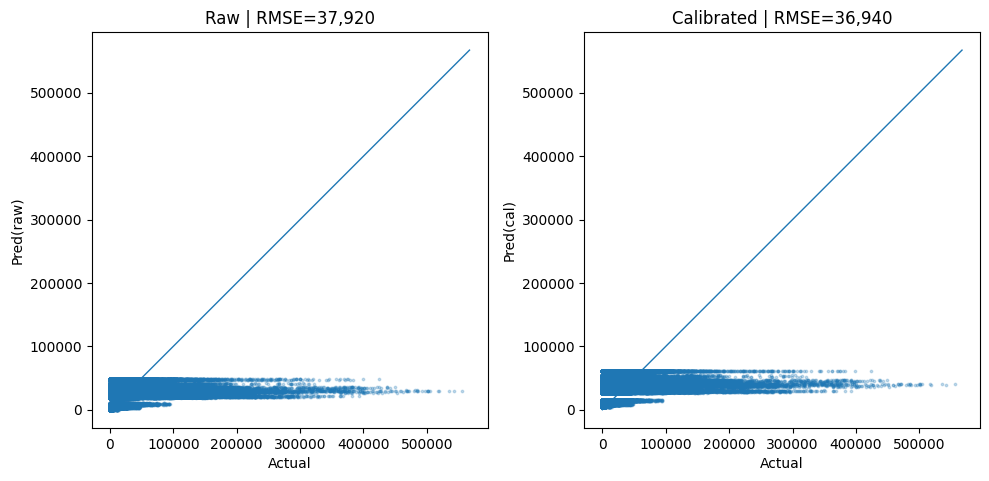

In [104]:
# ===== 2) 산점도 (전체) : 보정 전/후 비교 =====
m = float(max(y.max(), p0.max(), p1.max())) * 1.02

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y, p0, s=3, alpha=0.25)
plt.plot([0,m],[0,m], lw=1)
plt.title(f"Raw | RMSE={rmse_raw:,.0f}")
plt.xlabel("Actual"); plt.ylabel("Pred(raw)")
plt.gca().set_aspect('equal','box')

plt.subplot(1,2,2)
plt.scatter(y, p1, s=3, alpha=0.25)
plt.plot([0,m],[0,m], lw=1)
plt.title(f"Calibrated | RMSE={rmse_cal:,.0f}")
plt.xlabel("Actual"); plt.ylabel("Pred(cal)")
plt.gca().set_aspect('equal','box')
plt.tight_layout()
plt.show()

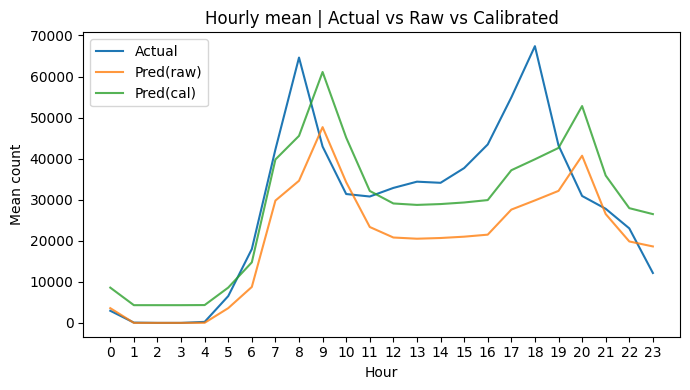

In [105]:
# ===== 3) 시간대 평균 라인플롯 (실제 vs 보정 전/후) =====
g = out.groupby("hour")[["congestion","pred_raw","pred_cal"]].mean().reset_index()

plt.figure(figsize=(7,4))
plt.plot(g["hour"], g["congestion"], label="Actual")
plt.plot(g["hour"], g["pred_raw"], label="Pred(raw)", alpha=0.8)
plt.plot(g["hour"], g["pred_cal"], label="Pred(cal)", alpha=0.8)
plt.xticks(range(int(g["hour"].min()), int(g["hour"].max())+1))
plt.xlabel("Hour"); plt.ylabel("Mean count")
plt.title("Hourly mean | Actual vs Raw vs Calibrated")
plt.legend(); plt.tight_layout(); plt.show()

In [106]:
# === A. 검증셋에서 역/시간대 보정계수 추정 ===
import numpy as np
import pandas as pd

# 1) 검증셋 예측(로그→카운트)
pred_va_log = gru.predict(X_va, batch_size=4096, verbose=0).ravel()
pred_va_cnt = np.expm1(pred_va_log).clip(min=0)
y_va_cnt    = np.expm1(y_va).clip(min=0)

val_df = meta_va.copy()
val_df["y"] = y_va_cnt
val_df["p"] = pred_va_cnt

# 2) 역/시간대 보정 준비 (역·노선·시간 선택)
LINE = "2호선"
ST   = "역삼"

mask_val = (val_df["호선명"]==LINE) & (val_df["지하철역"]==ST)

# (a) 역 단위 총량 보정 k_sta
k_sta = float(val_df.loc[mask_val, "y"].sum() / max(val_df.loc[mask_val, "p"].sum(), 1e-9))

# (b) 역-시간대(hour)별 보정 k_sth  (과도한 보정 방지 clip)
tmp = (val_df.loc[mask_val]
          .groupby("hour")[["y","p"]].sum()
          .assign(ratio=lambda g: g["y"] / g["p"].clip(lower=1e-9)))
k_sth = tmp["ratio"].clip(0.6, 1.8)

print(f"[{LINE} {ST}] k_sta={k_sta:.3f}")
print(k_sth.head())

[2호선 역삼] k_sta=5.977
hour
0    1.800000
1    1.800000
2    0.830113
3    0.600000
4    1.800000
Name: ratio, dtype: float32


RMSE raw : 141,811
RMSE cal : 134,728  (전역+시간대 보정)
RMSE sta : 67,020  (역 단일 보정)
RMSE sth : 129,481  (역+시간대 보정)


/tmp/ipython-input-1593890970.py:35: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.tight_layout(); plt.show()
/tmp/ipython-input-1593890970.py:35: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.tight_layout(); plt.show()
/tmp/ipython-input-1593890970.py:35: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.tight_layout(); plt.show()
/tmp/ipython-input-1593890970.py:35: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) m

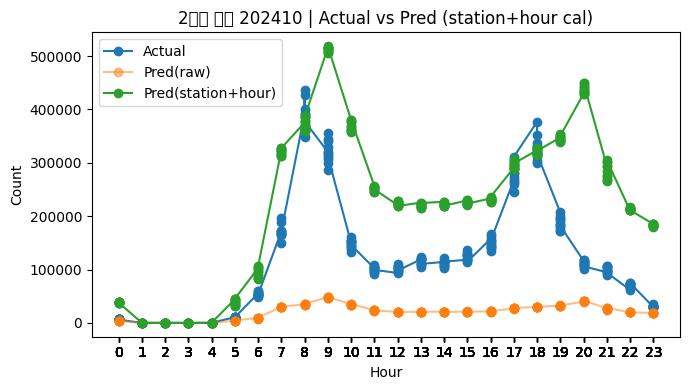

In [107]:
# === B. 테스트셋(out)에서 역/시간대 보정 적용 & 성능 확인 ===
def rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a-b)**2)))

# out: 테스트셋 결과 DF (columns: 사용월,호선명,지하철역,hour, congestion, pred_raw, pred_cal)
mask_te = (out["호선명"]==LINE) & (out["지하철역"]==ST)

# 역 단위 보정
out.loc[mask_te, "pred_sta"] = out.loc[mask_te, "pred_raw"] * k_sta

# 역-시간대 보정(역 단위 × 시간대 비율)
out.loc[mask_te, "pred_sth"] = (
    out.loc[mask_te, "pred_raw"] *
    k_sta *
    out.loc[mask_te, "hour"].map(k_sth).fillna(1.0)
)

# 성능 비교 출력
s = out.loc[mask_te, ["hour","congestion","pred_raw","pred_cal","pred_sta","pred_sth"]].sort_values("hour")
print("RMSE raw :", f"{rmse(s['congestion'], s['pred_raw']):,.0f}")
print("RMSE cal :", f"{rmse(s['congestion'], s['pred_cal']):,.0f}  (전역+시간대 보정)")
print("RMSE sta :", f"{rmse(s['congestion'], s['pred_sta']):,.0f}  (역 단일 보정)")
print("RMSE sth :", f"{rmse(s['congestion'], s['pred_sth']):,.0f}  (역+시간대 보정)")

# 간단 시계열 플롯 (리포트용)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(s["hour"], s["congestion"], marker="o", label="Actual")
plt.plot(s["hour"], s["pred_raw"], marker="o", alpha=0.5, label="Pred(raw)")
plt.plot(s["hour"], s["pred_sth"], marker="o", label="Pred(station+hour)")
plt.xticks(s["hour"]); plt.xlabel("Hour"); plt.ylabel("Count")
ym = int(out.loc[mask_te, "사용월"].min())
plt.title(f"{LINE} {ST} {ym} | Actual vs Pred (station+hour cal)")
plt.legend(); plt.tight_layout(); plt.show()

In [108]:
from tensorflow import keras

model.save("final_gru_model.keras")

loaded_model = keras.models.load_model("final_gru_model.keras")

pred = loaded_model.predict(X_test)

15524/15524 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
